# 04_hyperparameter_tuning: Tune the Random Forest Model

Date: 2022-06-14

## Prep Data

In [44]:
import os
#os.chdir('..')
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import plotly.express as px
import joblib

In [3]:
# set seed 
np.random.seed(42)

# read in data sets
training_cleaned = pd.read_pickle('cleaned_data/training_cleaned.pkl')
training_prices = pd.read_pickle('cleaned_data/training_prices.pkl')
test_orig = pd.read_csv('data/test.csv')
test = pd.read_pickle('cleaned_data/test_cleaned.pkl')

In [4]:
X = training_cleaned.copy()

#log transform the prices
y = np.log10(training_prices)

## Random Forest Regression

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [46]:
# create baseline model 
forest_reg = RandomForestRegressor()
# cross validation 
scores = cross_val_score(forest_reg, X, y, scoring = "neg_mean_squared_error", cv = 3)
rf_rmse_scores = np.sqrt(-scores)
baseline_rmse = rf_rmse_scores.mean()
baseline_rmse

#save model 
joblib.dump(forest_reg, 'Results/models/rf_baseline.sav')

['Results/models/rf_baseline.sav']

In [7]:
# see what are default parameters
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
# create grid 
param_grid = [
    {'n_estimators': [5, 10, 100, 400],
     'max_features': [5, 100, 'auto'],
     'bootstrap': [True, False], 
     'min_samples_split': [2, 5, 8]}] 
grid_search = GridSearchCV(forest_reg, param_grid, cv = 3, scoring = 'neg_mean_squared_error', return_train_score = True, verbose = 3)
grid_search.fit(X, y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=5;, score=(train=-0.002, test=-0.006) total time=   0.0s
[CV 2/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=5;, score=(train=-0.001, test=-0.009) total time=   0.1s
[CV 3/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=5;, score=(train=-0.002, test=-0.006) total time=   0.0s
[CV 1/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=10;, score=(train=-0.001, test=-0.006) total time=   0.0s
[CV 2/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=10;, score=(train=-0.001, test=-0.007) total time=   0.0s
[CV 3/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=10;, score=(train=-0.001, test=-0.005) total time=   0.0s
[CV 1/3] END bootstrap=True, max_features=5, min_samples_split=2, n_estimators=100;, score=(train=-0.001, test=-0.005) 

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [5, 100, 'auto'],
                          'min_samples_split': [2, 5, 8],
                          'n_estimators': [5, 10, 100, 400]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [34]:
# get best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=100, n_estimators=400)

In [35]:
cvres = grid_search.cv_results_

In [36]:
# get parameters and results
test_rmse = np.sqrt(-cvres['mean_test_score'])
train_rmse = np.sqrt(-cvres['mean_train_score'])
parameters = cvres['params']
bootstrap = [parameters[i]['bootstrap'] for i in range(len(parameters))]
max_features = [parameters[i]['max_features'] for i in range(len(parameters))]
n_estimators = [parameters[i]['n_estimators'] for i in range(len(parameters))]
min_samples_split = [parameters[i]['min_samples_split'] for i in range(len(parameters))]
per_improv = [(baseline_rmse-test)/baseline_rmse for test in test_rmse]

# combine into dataframe

cvrse_df = pd.DataFrame({'test_rmse': test_rmse, 
                        'train_rmse': train_rmse, 
                        'percent_improvement': per_improv, 
                        'bootstrap': bootstrap, 
                        'max_features': max_features, 
                        'n_estimators': n_estimators,
                        'min_samples_split': min_samples_split})

In [37]:
cvrse_df.sort_values(by = 'percent_improvement', ascending = False).head(10)

,test_rmse,train_rmse,percent_improvement,bootstrap,max_features,n_estimators,min_samples_split
51,0.059390,3.093359e-14,0.071816,False,100,400,2
55,0.059492,6.707912e-03,0.070230,False,100,400,5
59,0.059690,1.267933e-02,0.067133,False,100,400,8
54,0.059963,7.070595e-03,0.062869,False,100,100,5
50,0.060047,7.795554e-15,0.061554,False,100,100,2
58,0.060315,1.288446e-02,0.057370,False,100,100,8
18,0.060919,2.675810e-02,0.047925,True,100,100,5
15,0.060929,2.279545e-02,0.047770,True,100,400,2
23,0.060962,3.077534e-02,0.047254,True,100,400,8
14,0.060965,2.382820e-02,0.047201,True,100,100,2


There is a large difference in training and testing RMSE indicating overfitting. The best fit is a 7% improvement over the baseline (using defaults). 

### Parallel Coordinates Plot of Hyperparameters

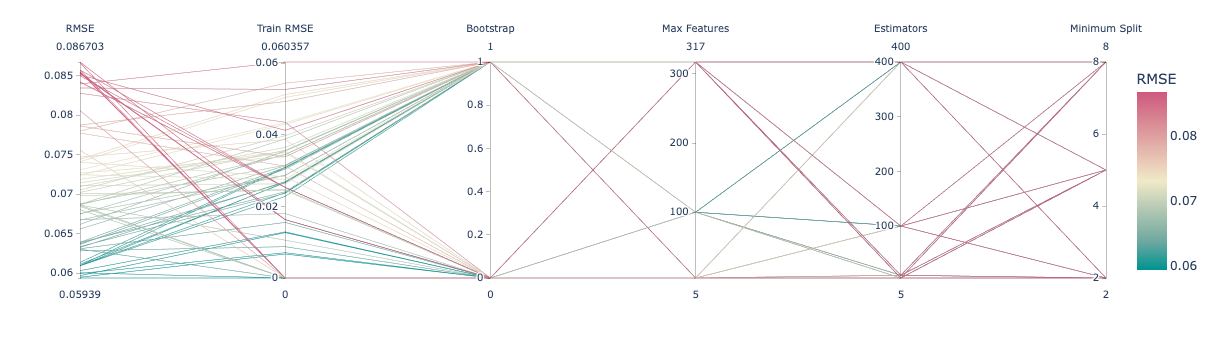

In [40]:
# had to 'pip install "notebook>=5.3" "ipywidgets>=7.2"' for this to show up.
fit_plot = cvrse_df[['test_rmse', 'train_rmse', 'bootstrap', 'max_features', 'n_estimators', 'min_samples_split']].copy()
fit_plot['bootstrap'] = [1 if i else 0 for i in fit_plot['bootstrap']]
fit_plot['max_features'] = [317 if i == 'auto' else i for i in fit_plot['max_features']]
fig = px.parallel_coordinates(fit_plot, color = 'test_rmse', 
                              labels = {'test_rmse': 'RMSE', 
                                        'train_rmse': 'Train RMSE', 
                                        'bootstrap': 'Bootstrap', 
                                        'max_features': 'Max Features', 
                                        'n_estimators': 'Estimators',
                                        'min_samples_split': 'Minimum Split'}, 
                              color_continuous_scale = px.colors.diverging.Tealrose)
fig.show()

Observations: 
- Bootstrapping seems to reduce overfitting by a bit (higher Train RMSE, and closer to Test RMSE) 
- Lower RMSE with ~ 100 maximum features 
- Lower RMSE with higher number of estimators 
- Minimum split doesn't really matter

In [43]:
# Apply best estimator on test set

model_hp = grid_search.best_estimator_
predictions = model_hp.predict(test)

# function to put predicted data in submission format 
def submission_format(predictions, test_orig):
    """
    predictions: output of predict() from running model 
    test_orig: original test data to get ID 
    
    returns: predictions with ID and applied exponential to undo log transform
    """
    # create data frame with id
    predictions_df = pd.DataFrame({'Id': test_orig['Id'], 
                               'SalePrice': predictions.tolist()})
    # log transform back the sale price
    predictions_df['SalePrice'] = 10**predictions_df['SalePrice']
    
    return predictions_df

predictions_df = submission_format(predictions, test_orig)
predictions_df.head()

predictions_df.to_csv('results/prediction_rf_hp.csv', index = False)

In [47]:
#save model 
joblib.dump(model_hp, 'Results/models/rf_hp_tuned_1.sav')

['Results/models/rf_hp_tuned_1.sav']

On Kaggle, this receives a score of 0.13819. From the difference between this score and expected RMSE (0.06), we need to address overfitting. 

Using a simple decision tree had recieved a score of 0.20352 prior. 